In [1]:
import json
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython import display

In [2]:
photo_path = './photo/'
json_path = './json-data/'
train_path = './b_w_image/'
test_path = './test/'

# MSER based text region detection

## Detecting text region proposals

In [7]:
def get_text_region_proposals(image, min_area=300, max_area=3000, delta=3):
    mser = cv2.MSER_create()
    mser.setMinArea(min_area)
    mser.setMaxArea(max_area)
    mser.setDelta(delta)
    coordinates, _ = mser.detectRegions(image)    
    bbs = []
    for coord in coordinates:
        bbox = cv2.boundingRect(coord)
        x, y, w, h = bbox
        if w < 10 or h < 10 or w/h > 5 or h/w > 5:
            continue
        bbs.append((x, y, w, h))
    return bbs

In [49]:
image = cv2.imread(train_path+'183786.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

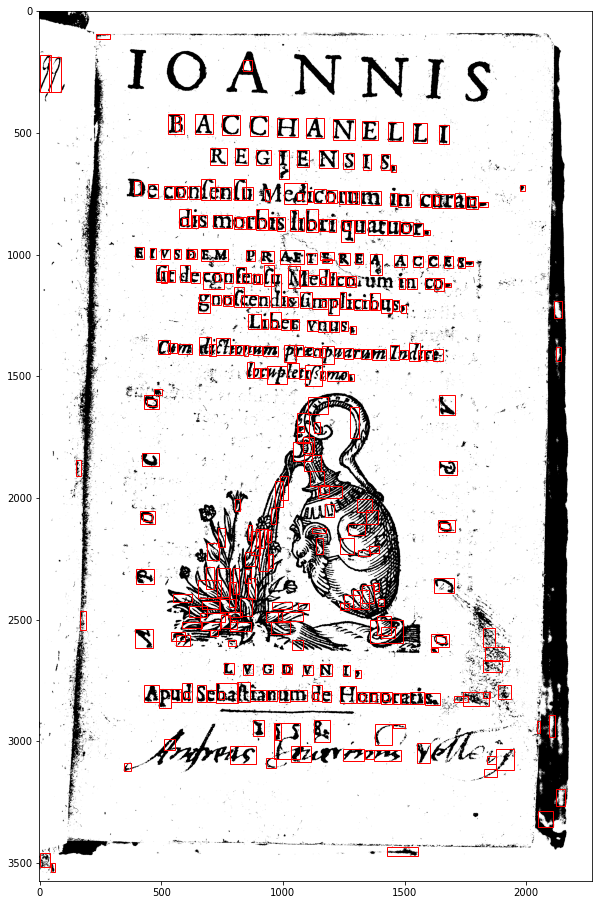

In [50]:
fig, ax = plt.subplots(1, figsize=(18, 16))
bbs = get_text_region_proposals(image)
ax.imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    ax.add_patch(rect)
display.display(plt.gcf())
display.clear_output(wait=True)

## Detecting boundings of passages

In [8]:
def dilate_bbs(bbs, dilation_d, dilation_max):
    bbs_l = []
    for bb in bbs:
        (x, y, w, h) = bb
        (centre_x, centre_y) = (x + w/2, y + h/2)
        (x1, y1, x2, y2) = (x, y, x + w, y + h)

        dx = (centre_x - x1) * dilation_d
        dy = (centre_y - y1) * dilation_d
        
        if dilation_max:
            if dx > dilation_max[0]:
                dx = dilation_max[0]
            if dy > dilation_max[1]:
                dy = dilation_max[1]

        x1_l = centre_x - dx
        y1_l = centre_y - dy
        x2_l = centre_x + dx
        y2_l = centre_y + dy

        bb_l = (int(x1_l), int(y1_l), int(x2_l - x1_l), int(y2_l - y1_l))
        bbs_l.append(bb_l)
    return bbs_l

In [9]:
def does_rect_overlap(bb1, bb2):
    (x1_1, y1_1, w_1, h_1) = bb1
    (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)
    
    (x1_2, y1_2, w_2, h_2) = bb2
    (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

    h_overlaps = True
    v_overlaps = True
    if (x1_1 > x2_2) or (x2_1 < x1_2):
        h_overlaps = False
    if (y1_1 > y2_2) or (y2_1 < y1_2):
        v_overlaps = False
    return h_overlaps and v_overlaps

In [10]:
def get_intersection_percentage(bb1, bb2):
    # How much of bb1 is intersecting with bb2
    if not does_rect_overlap(bb1, bb2):
        return 0

    (x1_1, y1_1, w_1, h_1) = bb1
    (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)
    
    (x1_2, y1_2, w_2, h_2) = bb2
    (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

    x_a = max(x1_1, x1_2)
    y_a = max(y1_1, y1_2)
    x_b = min(x2_1, x2_2)
    y_b = min(y2_1, y2_2)

    inter_area = (x_b - x_a + 1) * (y_b - y_a + 1)

    bb1_area = (w_1 + 1) * (h_1 + 1)
    bb2_area = (w_2 + 1) * (h_2 + 1)

    intersection_percentage = inter_area / float(bb1_area)
    return intersection_percentage

In [11]:
def get_intersection_percentage_matrix(bbs):
    n = len(bbs)
    ip = np.zeros(shape=(n, n))
    for i in range(n):
        for j in range(n):
            ip[i, j] = get_intersection_percentage(bbs[i], bbs[j])
    return ip 

In [12]:
def make_new_bb_from_intersect_bbs(bbs):
    max_x = np.max([bb[0] + bb[2] for bb in bbs])
    min_x = np.min([bb[0] for bb in bbs])
    max_y = np.max([bb[1] + bb[3] for bb in bbs])
    min_y = np.min([bb[1] for bb in bbs])
    return (min_x, min_y, max_x - min_x, max_y - min_y)

In [13]:
def reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded):
    new_bbs = []
    for i in range(in_matrix_thresholded.shape[0]):
        in_i = in_matrix_thresholded[i, :]
        intersections_indexes = np.where(in_i)[0]
        if len(intersections_indexes) == 0:
            new_bbs.append(bbs[i])
        else:
            intersection_bbs = [bbs[i]]
            for intersections_index in intersections_indexes:
                intersection_bbs.append(bbs[intersections_index])
            new_bb = make_new_bb_from_intersect_bbs(intersection_bbs)
            if new_bb not in new_bbs:
                new_bbs.append(new_bb)
    return new_bbs

In [14]:
def reduce_intersecting_bbs(bbs, intersection_threshold):
    new_bbs = bbs
    while True:
        old_bbs_no = len(bbs)
        in_matrix = get_intersection_percentage_matrix(bbs)
        in_matrix_thresholded = in_matrix > intersection_threshold
        bbs = reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded)
        if old_bbs_no == len(bbs):
            break
    return bbs

In [15]:
def get_bounding_boxs_of_passages(bbs, iterations, ip_threshold, dilation_d, dilation_max=None, intermetiate_bbs=None):
    '''    
    Parameters
    ----------
    iterations: int

    ios_threshold: 

    dilation_d: float
        percentage to increase the bounding box

    '''
    for i in range(iterations):
        bbs = dilate_bbs(bbs, dilation_d, dilation_max)
        bbs = reduce_intersecting_bbs(bbs, ip_threshold)
        if intermetiate_bbs is not None:
            intermetiate_bbs.append(bbs)
        print("Running {}/{}, new #bbs {}".format(i, iterations, len(bbs)))
    return bbs

## Testing dilation

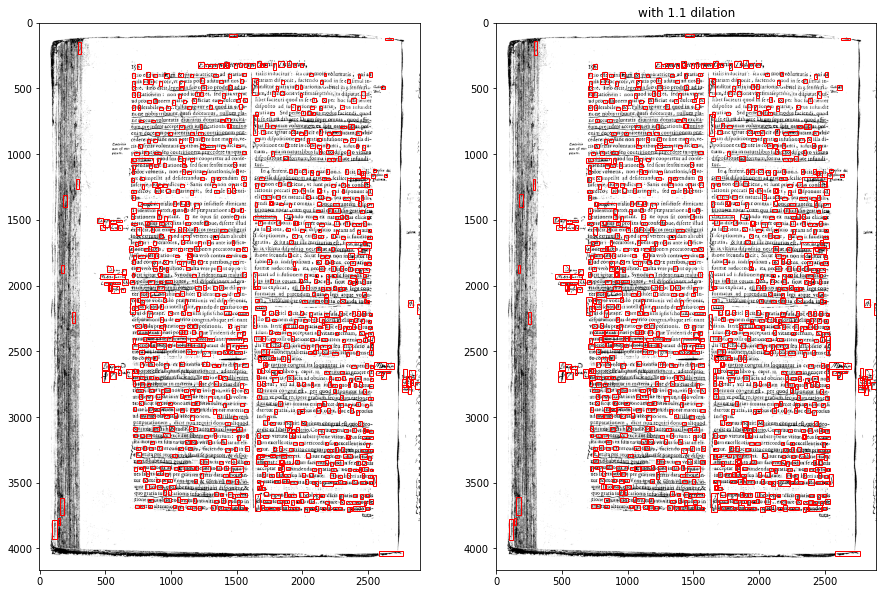

In [74]:
dilation_d = 1.1

bbs = get_text_region_proposals(image)
bbs_l = dilate_bbs(bbs, dilation_d, None)
fig, axs = plt.subplots(1, 2, figsize=(15, 13))

axs[0].imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[0].add_patch(rect)
axs[1].imshow(image, cmap='Greys_r')
axs[1].set_title("with {} dilation".format(dilation_d))
for (x, y, w, h) in bbs_l:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[1].add_patch(rect)

## Testing intersections

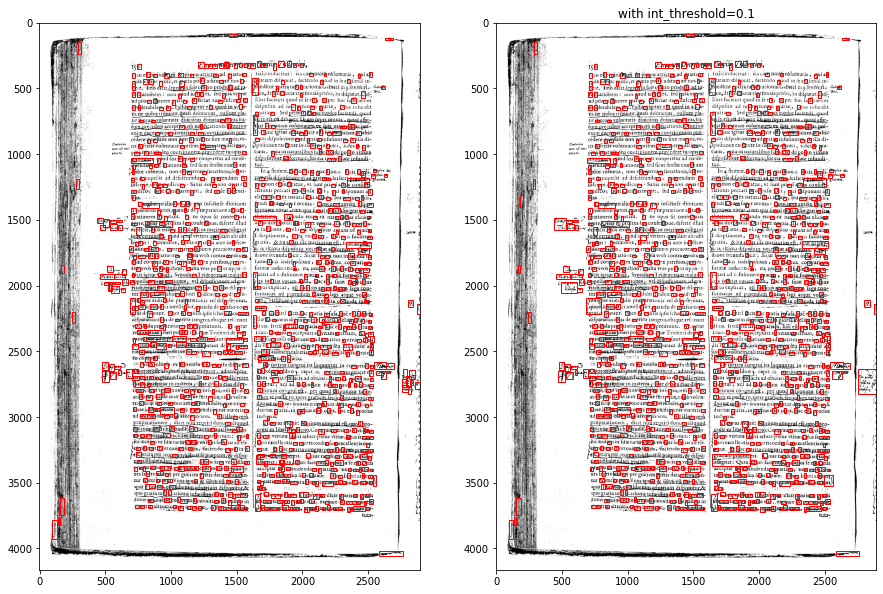

In [75]:
intersection_threshold = 0.1

bbs = get_text_region_proposals(image)
bbs_l = reduce_intersecting_bbs(bbs, intersection_threshold)

fig, axs = plt.subplots(1, 2, figsize=(15, 13))

axs[0].imshow(image, cmap='Greys_r')
for (x, y, w, h) in bbs:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[0].add_patch(rect)
axs[1].imshow(image, cmap='Greys_r')
axs[1].set_title("with int_threshold={}".format(intersection_threshold))
for (x, y, w, h) in bbs_l:
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[1].add_patch(rect)

## Passage bounding boxes detection

In [72]:
def plot_intermediate_bbs(intermetiate_bbs, iterations):
    fig, axs = plt.subplots(1, iterations, figsize=(12 * iterations, 15))
    for i, bb in enumerate(intermetiate_bbs):
        axs[i].imshow(image, cmap='Greys_r')
        for (x, y, w, h) in bb:
            rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
            axs[i].add_patch(rect)
        axs[i].set_title("At iteration={} #bbs {}".format(i+1, len(bb)))
        axs[i].imshow(image, cmap='Greys_r')

Running 0/3, new #bbs 911
Running 1/3, new #bbs 762
Running 2/3, new #bbs 626


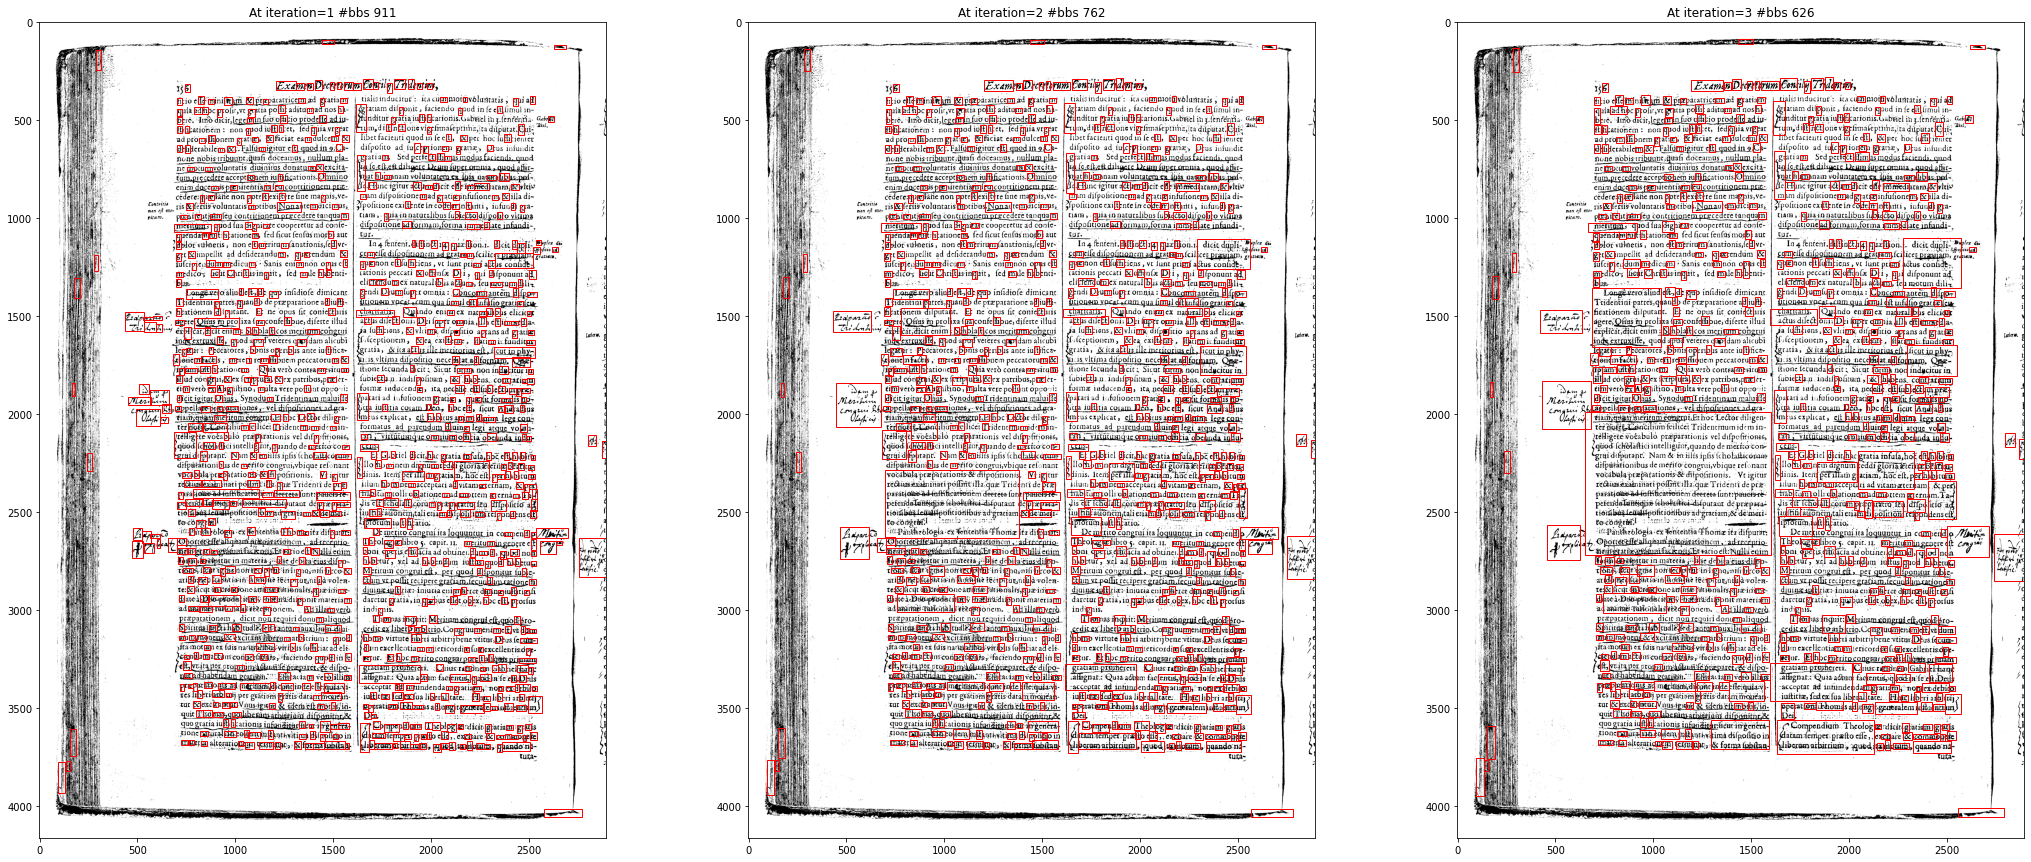

In [73]:
#image = cv2.imread(train_path+'183786.png')
image = cv2.imread(train_path+'194694.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

iterations = 3
dilation_d = 1.1
dilation_max = (300, 300)
intersection_threshold = 0.1

bbs = get_text_region_proposals(image)
intermetiate_bbs = []
bbs_l = get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                    dilation_max, intermetiate_bbs)
plot_intermediate_bbs(intermetiate_bbs, iterations)

## Segmentation for test data

In [65]:
def segmentation(id, test_coordinates):
    image = cv2.imread(train_path+str(id)+'.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    iterations = 3
    dilation_d = 1.1
    dilation_max = (300, 300)
    intersection_threshold = 0.1

    bbs = get_text_region_proposals(image)
    intermetiate_bbs = []
    bbs_l = get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                        dilation_max, intermetiate_bbs)
    test_coordinates[int(id)] = intermetiate_bbs[-1]

In [93]:
new_test_coordinates_l = {}
file = pd.read_csv('data.csv')
id = file['number'].unique()
for i in id:
    #segmentation(i, test_coordinates)
    b = []
    for j in new_test_coordinates[i]:
        a = []
        for k in j:
            a.append(int(k))
        b.append(a)
    new_test_coordinates_l[int(i)] = b

In [ ]:
with open('test_coordinates.json', 'w') as f:
    json.dump(new_test_coordinates_l, f)

In [3]:
with open('test_coordinates.json') as f:
    new_test_coordinates = json.load(f)

## Preprocess test data

In [4]:
test_cut = {}
for i in new_test_coordinates.keys():
    print(i)
    img_path = train_path+i+'.png'
    im = cv2.imread(img_path)
    a = 0
    for j in new_test_coordinates[str(i)]:
        # remove the tiny box
        if j[3] > 60 and j[2] > 60:
            b, c = j[1]+j[3], j[0]+j[2]
            if j[1] < 0:
                j[1] = 0
            if j[0] < 0:
                j[0] = 0
            name = i+'_'+str(a)
            b, c = j[1]+j[3], j[0]+j[2]
            ims = im[j[1]:b, j[0]:c]
            test_cut[name] = [int(j[2]), int(j[3])]
            cv2.imwrite('./test_cut/'+i+'_'+str(a)+'.png', ims)
        a += 1

183786
183844
183845
183846
183847
183855
183862
183867
183868
183869
183874
183876
183878
183881
183919
183942
183943
183971
184010
184011
184012
184015
184018
184064
184065
184067
184068
184076
184078
184101
184102
184104
184105
184127
184130
184145
184146
184148
184156
184157
184159
184251
184252
184253
184255
184257
184258
184259
184260
184261
184262
184263
184266
184267
184269
184270
184283
184284
184293
184294
184296
184298
184301
184305
184307
184310
184322
184328
184331
184332
184334
184335
184337
184338
184400
184404
184406
184407
184409
184410
184411
184412
184413
184414
184415
184416
184423
184425
184426
184427
184429
184430
184431
184542
184545
184547
184549
184550
184554
184578
184579
184585
184586
184597
184600
184965
184969
184970
184975
185010
185011
185017
185019
185020
185022
185079
185080
185081
185082
185084
185093
185096
185097
185099
186510
186512
186515
186519
186523
186524
186525
186526
186528
186535
186537
186538
186542
186543
186545
186546
186548
186550
186553

In [5]:
with open('test_shape.json', 'w') as f:
    json.dump(test_cut, f)

In [6]:
def pre_data(j):
    img = cv2.imread('./test_cut/'+j+'.png')
    kernel = np.ones((2, 2), np.uint8)
    opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    #closing = cv2.morphologyEx(threshold, cv2.MORPH_CLOSE, kernel)
    if (opening.shape[0]>=opening.shape[1] and (opening.shape[0]/opening.shape[1])<=2.1) or (opening.shape[0]<=opening.shape[1] and (opening.shape[1]/opening.shape[0])<=2.1):
        resized_image = cv2.resize(opening, (227, 227))
        cv2.imwrite(test_path+j+'_'+'.png', resized_image)
    elif opening.shape[0]>opening.shape[1] and (opening.shape[0]/opening.shape[1])>2.1:
        n = int(opening.shape[0] / opening.shape[1])
        dis_h = int(np.floor(opening.shape[0] / n))
        for i in range(n):
            a = i+1
            sub = opening[i*dis_h:(i+1)*dis_h, 0:opening.shape[1]]
            resized_image = cv2.resize(sub, (227, 227))
            cv2.imwrite(test_path+j+'_'+str(a)+'.png', resized_image)
    elif opening.shape[0]<opening.shape[1] and (opening.shape[1]/opening.shape[0])>2.1:
        n = int(opening.shape[1] / opening.shape[0])
        dis_w = int(np.floor(opening.shape[1] / n))
        for i in range(n):
            a = i+1
            sub = opening[0:opening.shape[0], i*dis_w:(i+1)*dis_w]
            resized_image = cv2.resize(sub, (227, 227))
            cv2.imwrite(test_path+j+'_'+str(a)+'.png', resized_image)
    print(j)

In [7]:
for j in test_cut.keys():
    pre_data(j)

183786_0
183786_1
183786_2
183786_4
183786_5
183786_6
183786_7
183786_9
183786_10
183786_12
183786_13
183786_14
183786_15
183786_19
183786_20
183786_21
183786_22
183786_24
183786_25
183786_26
183786_27
183786_28
183786_30
183786_32
183786_33
183786_34
183786_36
183786_37
183786_38
183786_39
183786_40
183786_41
183786_43
183786_44
183786_45
183786_46
183786_47
183786_48
183786_49
183786_50
183786_51
183786_52
183786_54
183786_55
183786_57
183786_58
183786_61
183786_62
183786_64
183786_69
183786_70
183786_71
183786_72
183786_73
183786_74
183786_75
183786_76
183786_83
183786_84
183786_87
183844_1
183844_2
183844_3
183844_6
183844_7
183844_9
183844_10
183844_12
183844_13
183844_16
183844_18
183844_20
183844_24
183844_25
183844_27
183844_31
183844_48
183845_0
183845_1
183845_2
183845_5
183845_6
183845_8
183845_10
183845_11
183845_15
183845_18
183845_23
183845_27
183845_28
183845_29
183845_30
183845_31
183845_36
183845_37
183845_40
183845_42
183845_43
183845_47
183845_48
183845_51
183845_52


In [10]:
with open ('test_coordinates.json') as f:
    test_coordinates = json.load(f)

with open ('test_shape.json') as f:
    test_shape = json.load(f)

new_test_coordinates = {}
for i in test_coordinates.keys():
    new_test_coordinates[i] = []

In [16]:
for i in test_shape.keys():
    print(i.split('_')[0], i.split('_')[1])
    new_test_coordinates[i.split('_')[0]].append(test_coordinates[i.split('_')[0]][int(i.split('_')[1])])

with open('new_test_coordinates.json', 'w') as f:
    json.dump(new_test_coordinates, f)


183786 0
183786 1
183786 2
183786 4
183786 5
183786 6
183786 7
183786 9
183786 10
183786 12
183786 13
183786 14
183786 15
183786 19
183786 20
183786 21
183786 22
183786 24
183786 25
183786 26
183786 27
183786 28
183786 30
183786 32
183786 33
183786 34
183786 36
183786 37
183786 38
183786 39
183786 40
183786 41
183786 43
183786 44
183786 45
183786 46
183786 47
183786 48
183786 49
183786 50
183786 51
183786 52
183786 54
183786 55
183786 57
183786 58
183786 61
183786 62
183786 64
183786 69
183786 70
183786 71
183786 72
183786 73
183786 74
183786 75
183786 76
183786 83
183786 84
183786 87
183844 1
183844 2
183844 3
183844 6
183844 7
183844 9
183844 10
183844 12
183844 13
183844 16
183844 18
183844 20
183844 24
183844 25
183844 27
183844 31
183844 48
183845 0
183845 1
183845 2
183845 5
183845 6
183845 8
183845 10
183845 11
183845 15
183845 18
183845 23
183845 27
183845 28
183845 29
183845 30
183845 31
183845 36
183845 37
183845 40
183845 42
183845 43
183845 47
183845 48
183845 51
183845 52
